# This notebook allows for training and testing that is related to the OXIOD dataset. 

## Tests done so far:

Trained on individual domain training list, and tested on the testing list

## Import Dependencies

In [24]:
#import dependencies
! pip install tensorboardX
! pip install numpy-quaternion
! pip install h5py

Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [25]:
import os
import time
from os import path as osp

import numpy as np
import torch
import json
import math


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import interp1d
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader

from data_Oxiod import *
from transformations import *
from metric import compute_ate_rte
from model_resnet1d import *

In [26]:
import argparse
args = argparse.Namespace()

#Paths to different files
args.type = 'resnet'
args.root_dir = '/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/handheld'
args.train_list = osp.join(args.root_dir, 'Train.txt')
args.val_list = osp.join(args.root_dir, 'Validation.txt')
args.test_list = osp.join(args.root_dir, 'Test.txt')
args.out_dir = osp.join(args.root_dir, args.type + '_outputs')
args.model_path = osp.join(args.out_dir, 'checkpoints/checkpoint_latest.pt')


args.test_path = None
args.cache_path = None
args.continue_from = None
args.transfer_from = None


# Params to tune for neural network
args.mode = "train"
args.step_size = 10
args.window_size = 200
args.lr = 1e-04
args.batch_size = 256
args.epochs = 80
args.freeze_params = False

# miscallaneous
args.arch = "resnet18"
args.cpu = False
args.run_ekf = False
args.fast_test = False

# Plots and animation
args.show_plot = True
args.saveAnim = True


np.set_printoptions(formatter={'all': lambda x: '{:.6f}'.format(x)})

In [27]:
_input_channel, _output_channel = 6, 2
_fc_config = {'fc_dim': 512, 'in_dim': 4, 'dropout': 0.5, 'trans_planes': 128}

In [28]:
def run_test(network, data_loader, device, eval_mode=True):
    targets_all = []
    preds_all = []
    if eval_mode:
        network.eval()
    for bid, (feat, targ, _, _) in enumerate(data_loader):
        pred = network(feat.to(device)).cpu().detach().numpy()
        targets_all.append(targ.detach().numpy())
        preds_all.append(pred)
    targets_all = np.concatenate(targets_all, axis=0)
    preds_all = np.concatenate(preds_all, axis=0)
    return targets_all, preds_all

In [29]:
def add_summary(writer, loss, step, mode):
    names = '{0}_loss/loss_x,{0}_loss/loss_y,{0}_loss/loss_z,{0}_loss/loss_sin,{0}_loss/loss_cos'.format(
        mode).split(',')

    for i in range(loss.shape[0]):
        writer.add_scalar(names[i], loss[i], step)
    writer.add_scalar('{}_loss/avg'.format(mode), np.mean(loss), step)

In [30]:
def get_dataset(root_dir, data_list, args, **kwargs):
    mode = kwargs.get('mode', 'train')

    random_shift, shuffle, transforms, grv_only = 0, False, None, False
    
    if mode == 'train':
        random_shift = args.step_size // 2
        shuffle = True
        #transforms = RandomHoriRotate(math.pi * 2)
        transforms = None
    elif mode == 'val':
        shuffle = True
    elif mode == 'test':
        shuffle = False
        grv_only = True

    seq_type = OxfordGlobSpeedSequence
    dataset = StridedSequenceDataset(seq_type, root_dir, data_list, args.cache_path, args.step_size, args.window_size, shuffle = shuffle, 
                                     grv_only=grv_only, transform = transforms, random_shift = random_shift)
    print(f'step_size: {dataset.step_size}, window_size: {dataset.window_size}')
    global _input_channel, _output_channel
    _input_channel, _output_channel = dataset.feature_dim, dataset.target_dim
    return dataset


def get_dataset_from_list(root_dir, list_path, args, **kwargs):
    with open(list_path) as f:
        data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    return get_dataset(root_dir, data_list, args, **kwargs)    

In [31]:
# # This is to get dataset with k fold validation
# def get_dataset(root_dir, data_list, args, **kwargs):
#     mode = kwargs.get('mode', 'train')

#     random_shift, shuffle, transforms, grv_only = 0, False, None, False
    
    
    
#     if mode == 'train':
#         random_shift = args.step_size // 2
#         shuffle = True
#         #transforms = RandomHoriRotate(math.pi * 2)
#         transforms = None
#     elif mode == 'val':
#         shuffle = True
#     elif mode == 'test':
#         shuffle = False
#         grv_only = True
        
#     # Do k fold cross validation
#     elif mode == 'kfold':
#         random_shift = args.step_size // 2
#         shuffle = True
#         transforms = None
        
#         import random

#         val_size = 1

#         # Randomly select elements for the first part
#         val_list = random.sample(data_list, val_size)

#         # Create the second part by excluding the elements in part1
#         train_list = [item for item in data_list if item not in val_list]
        
#         print('kfold happening!')
#         print('val list: ', val_list)
#         print('train list: ', train_list)
        
#         seq_type = OxfordGlobSpeedSequence
#         train_dataset = StridedSequenceDataset(seq_type, root_dir, train_list, args.cache_path, args.step_size, args.window_size, shuffle = shuffle, 
#         grv_only=grv_only, transform = transforms, random_shift = random_shift)
        
#         val_dataset = StridedSequenceDataset(seq_type, root_dir, val_list, args.cache_path, args.step_size, args.window_size, shuffle = False, 
#         grv_only=grv_only, transform = None, random_shift = 0)
        
#         return train_dataset, val_dataset
        

#     seq_type = OxfordGlobSpeedSequence
#     dataset = StridedSequenceDataset(seq_type, root_dir, data_list, args.cache_path, args.step_size, args.window_size, shuffle = shuffle, 
#                                      grv_only=grv_only, transform = transforms, random_shift = random_shift)
#     print(f'step_size: {dataset.step_size}, window_size: {dataset.window_size}')
#     global _input_channel, _output_channel
#     _input_channel, _output_channel = dataset.feature_dim, dataset.target_dim
#     return dataset


# def get_dataset_from_list(root_dir, list_path, args, **kwargs):
#     with open(list_path) as f:
#         data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
#     return get_dataset(root_dir, data_list, args, **kwargs)    

In [32]:
def recon_traj_with_preds(dataset, preds, seq_id=0, **kwargs):
    """
    Reconstruct trajectory with predicted global velocities.
    """
    ts = dataset.ts[seq_id]
    ind = np.array([i[1] for i in dataset.index_map if i[0] == seq_id], dtype=np.int32) # Gets an array of frame IDs which correspond to the sequence. This sequence knows the window size and step size
    #dts = 0.01
    dts = np.mean(ts[ind[1:]] - ts[ind[:-1]])

    pos = np.zeros([preds.shape[0] + 2, 2])
    # initial position using first position value
    pos[0] = dataset.gt_pos[seq_id][0, :2]
    
    # the intermediate positions using the time interval and adding to initial position
    pos[1:-1] = np.cumsum(preds[:, :2] * dts, axis=0) + pos[0]
    pos[-1] = pos[-2]
    
    print('length of pos_pred in func (bfore inter: ', pos.shape)
    
    # This does interpolation because we do not have positions for every timestep. [ts[0] +/- 1e-06] corresponds to the end with an additional small value
    ts_ext = np.concatenate([[ts[0] - 1e-06], ts[ind], [ts[-1] + 1e-06]], axis=0)
    pos = interp1d(ts_ext, pos, axis=0)(ts)
    print(f'pos shape final: {pos.shape}')
    return pos

In [33]:
def write_config(args):
    if args.out_dir:
        with open(osp.join(args.out_dir, 'config.json'), 'w') as f:
            json.dump(vars(args), f)

In [34]:
def showAnimation(video_path):
    import ipywidgets as widgets
    from IPython.display import display
    video_widget = widgets.Video.from_file(video_path)
    video_widget.controls = True
    video_widget.autoplay = True
    display(video_widget)

def plotTrajectory(true_x_values, true_y_values, pred_x_values, pred_y_values):    
    plt.figure('{}'.format("Trajectory"), figsize=(16, 9))

    length = len(true_x_values)
    multiplier = 50
    # creating a blank window
    # for the animation
    fig = plt.figure()
    min_x_value = np.min([np.min(true_x_values), np.min(pred_x_values)])
    max_x_value = np.max([np.max(true_x_values), np.max(pred_x_values)])
    min_y_value = np.min([np.min(true_y_values), np.min(pred_y_values)])
    max_y_value = np.max([np.max(true_y_values), np.max(pred_y_values)])
    
    
    axis = plt.axes(xlim =(min_x_value, max_x_value), ylim =(min_y_value, max_y_value))
    
    line1, = axis.plot([], [], 'b', label='Line 1')
    line2, = axis.plot([], [], 'r', label='Line 2')

    def init():
        line1.set_data([], [])
        return line1,
    def init():
        line2.set_data([], [])
        return line2,

    # initializing empty values
    # for x and y co-ordinates
    true_xdata, true_ydata, pred_xdata, pred_ydata = [], [], [], []

    # animation function
    def animate(i):
        true_x = true_x_values[i * multiplier]
        true_y = true_y_values[i * multiplier]
        pred_x = pred_x_values[i * multiplier]
        pred_y = pred_y_values[i * multiplier]
        
        true_xdata.append(true_x)
        true_ydata.append(true_y)
        pred_xdata.append(pred_x)
        pred_ydata.append(pred_y)
        
        line1.set_data(true_xdata, true_ydata)
        line2.set_data(pred_xdata, pred_ydata)

        return line1, line2

    # calling the animation function	
    anim = animation.FuncAnimation(fig, animate, init_func = init, frames = int(length/multiplier), interval = 0.01, blit = True)
    return anim

In [35]:
def train(args, **kwargs):
    # Loading data
    start_t = time.time()
    train_dataset = get_dataset_from_list(args.root_dir, args.train_list, args,  mode='train')
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

    end_t = time.time()
    print('Training set loaded. Feature size: {}, target size: {}. Time usage: {:.3f}s'.format(
        train_dataset.feature_dim, train_dataset.target_dim, end_t - start_t))
    
    val_dataset, val_loader = None, None
    if args.val_list is not None:
        val_dataset = get_dataset_from_list(args.root_dir, args.val_list, args, mode='val')
        val_loader = DataLoader(val_dataset, batch_size=512, shuffle=True)
    device = torch.device('cuda:0' if torch.cuda.is_available() and not args.cpu else 'cpu')

    summary_writer = None
    
    if args.out_dir is not None:
        if not osp.isdir(args.out_dir):
            os.makedirs(args.out_dir)
        write_config(args)
            
        if not osp.isdir(osp.join(args.out_dir, 'checkpoints')):
            os.makedirs(osp.join(args.out_dir, 'checkpoints'))
        if not osp.isdir(osp.join(args.out_dir, 'logs')):
            os.makedirs(osp.join(args.out_dir, 'logs'))

    global _fc_config
    _fc_config['in_dim'] = args.window_size // 32 + 1
    network = ResNet1D(_input_channel, _output_channel, BasicBlock1D, [2, 2, 2, 2],
                           base_plane=64, output_block=FCOutputModule, kernel_size=3, **_fc_config)
    network.to(device)

    
    
    print('Number of train samples: {}'.format(len(train_dataset)))
    if val_dataset:
        print('Number of val samples: {}'.format(len(val_dataset)))
    total_params = network.get_num_params()
    print('Total number of parameters: ', total_params)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), args.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True, eps=1e-12)

    start_epoch = 0
    
    # Continues from last model that was trained
    if args.continue_from is not None and osp.exists(args.continue_from):
        checkpoints = torch.load(args.continue_from)
        start_epoch = checkpoints.get('epoch', 0)
        network.load_state_dict(checkpoints.get('model_state_dict'))
        optimizer.load_state_dict(checkpoints.get('optimizer_state_dict'))
        
    # Transfer learns from model that was trained
    if args.transfer_from is not None and osp.exists(args.transfer_from):
        checkpoints = torch.load(args.transfer_from)
        network.load_state_dict(checkpoints.get('model_state_dict'))    
        print('loaded model from', args.transfer_from)
        if args.freeze_params:
            for param in network.parameters():
                param.requires_grad = False
        network.reset_output_block(BasicBlock1D, _output_channel, **_fc_config)
        optimizer = torch.optim.Adam(network.parameters(), args.lr)
        total_params = network.get_num_params()
        print('Total number of parameters: ', total_params)
        network.to(device)
        network.train()
        
    
    step = 0
    best_val_loss = np.inf

    print('Start from epoch {}'.format(start_epoch))
    total_epoch = start_epoch
    train_losses_all, val_losses_all = [], []

    # Get the initial loss, this should be with the randomised weights
    init_train_targ, init_train_pred = run_test(network, train_loader, device, eval_mode=False)

    init_train_loss = np.mean((init_train_targ - init_train_pred) ** 2, axis=0)
    train_losses_all.append(np.mean(init_train_loss))
    print('-------------------------')
    print('Init: average loss: {}/{:.6f}'.format(init_train_loss, train_losses_all[-1]))
    if summary_writer is not None:
        add_summary(summary_writer, init_train_loss, 0, 'train')

    if val_loader is not None:
        init_val_targ, init_val_pred = run_test(network, val_loader, device)
        init_val_loss = np.mean((init_val_targ - init_val_pred) ** 2, axis=0)
        val_losses_all.append(np.mean(init_val_loss))
        print('Validation loss: {}/{:.6f}'.format(init_val_loss, val_losses_all[-1]))
        if summary_writer is not None:
            add_summary(summary_writer, init_val_loss, 0, 'val')

    try:
        for epoch in range(start_epoch, args.epochs):
            #kfold training
            # train_dataset, val_dataset = get_dataset_from_list(args.root_dir, args.train_list, args,  mode='kfold')
            # train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
            # val_loader = DataLoader(val_dataset, batch_size=512, shuffle=True)
            
            
            start_t = time.time()
            network.train()
            train_outs, train_targets = [], []
            for batch_id, (feat, targ, _, _) in enumerate(train_loader):
                feat, targ = feat.to(device), targ.to(device)
                optimizer.zero_grad()
                pred = network(feat)
                train_outs.append(pred.cpu().detach().numpy())
                train_targets.append(targ.cpu().detach().numpy())
                loss = criterion(pred, targ)
                loss = torch.mean(loss)
                loss.backward()
                optimizer.step()
                step += 1
            train_outs = np.concatenate(train_outs, axis=0)
            train_targets = np.concatenate(train_targets, axis=0)
            train_losses = np.average((train_outs - train_targets) ** 2, axis=0)

            end_t = time.time()
            print('-------------------------')
            print('Epoch {}, time usage: {:.3f}s, average loss: {}/{:.6f}'.format(
                epoch, end_t - start_t, train_losses, np.average(train_losses)))
            train_losses_all.append(np.average(train_losses))

            if summary_writer is not None:
                add_summary(summary_writer, train_losses, epoch + 1, 'train')
                summary_writer.add_scalar('optimizer/lr', optimizer.param_groups[0]['lr'], epoch)

            #if we have a validation dataset, checkpoint is saved based on the best validation loss
            if val_loader is not None:
                network.eval()
                val_outs, val_targets = run_test(network, val_loader, device)
                val_losses = np.average((val_outs - val_targets) ** 2, axis=0)
                avg_loss = np.average(val_losses)
                print('Validation loss: {}/{:.6f}'.format(val_losses, avg_loss))
                scheduler.step(avg_loss)
                if summary_writer is not None:
                    add_summary(summary_writer, val_losses, epoch + 1, 'val')
                val_losses_all.append(avg_loss)
                if avg_loss < best_val_loss:
                    best_val_loss = avg_loss
                    if args.out_dir and osp.isdir(args.out_dir):
                        model_path = osp.join(args.out_dir, 'checkpoints', 'checkpoint_%d.pt' % epoch)
                        torch.save({'model_state_dict': network.state_dict(),
                                    'epoch': epoch,
                                    'optimizer_state_dict': optimizer.state_dict()}, model_path)
                        print('Model saved to ', model_path)
            else:
                if args.out_dir is not None and osp.isdir(args.out_dir):
                    model_path = osp.join(args.out_dir, 'checkpoints', 'checkpoint_%d.pt' % epoch)
                    torch.save({'model_state_dict': network.state_dict(),
                                'epoch': epoch,
                                'optimizer_state_dict': optimizer.state_dict()}, model_path)
                    print('Model saved to ', model_path)

            total_epoch = epoch

    except KeyboardInterrupt:
        print('-' * 60)
        print('Early terminate')

    print('Training complete')
    if args.out_dir:
        model_path = args.model_path
        torch.save({'model_state_dict': network.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': total_epoch}, model_path)
        print('Checkpoint saved to ', model_path)

    return train_losses_all, val_losses_all

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def simple_moving_average(data, window_size):
    """
    Calculate the simple moving average of a given data array using a specified window size.
    
    Args:
        data: The input data array.
        window_size: The size of the moving window.
    
    Returns:
        The array of simple moving averages.
    """
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size


In [37]:
def test_sequence(args):
    args.mode = 'test'
    if args.test_path is not None:
        if args.test_path[-1] == '/':
            args.test_path = args.test_path[:-1]
        root_dir = osp.split(args.test_path)[0]
        test_data_list = [osp.split(args.test_path)[1]]
    elif args.test_list is not None:
        root_dir = args.root_dir
        with open(args.test_list) as f:
            test_data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    else:
        raise ValueError('Either test_path or test_list must be specified.')

    if args.out_dir is not None and not osp.isdir(args.out_dir):
        os.makedirs(args.out_dir)

    if not osp.isdir(osp.join(args.out_dir, 'Videos')) or not osp.isdir(osp.join(args.out_dir, 'Graphs')):
        os.makedirs(osp.join(args.out_dir, 'Videos'))
        os.makedirs(osp.join(args.out_dir, 'Graphs'))

    if not torch.cuda.is_available() or args.cpu:
        device = torch.device('cpu')
        checkpoint = torch.load(args.model_path, map_location=lambda storage, location: storage)
    else:
        device = torch.device('cuda:0')
        checkpoint = torch.load(args.model_path)

    # Load the first sequence to update the input and output size
    _ = get_dataset(root_dir, [test_data_list[0]], args)

    global _fc_config
    _fc_config['in_dim'] = args.window_size // 32 + 1
    network = ResNet1D(_input_channel, _output_channel, BasicBlock1D, [2, 2, 2, 2],
                           base_plane=64, output_block=FCOutputModule, kernel_size=3, **_fc_config)

    network.load_state_dict(checkpoint['model_state_dict'])
    network.eval().to(device)
    print('Model {} loaded to device {}.'.format(args.model_path, device))

    preds_seq, targets_seq, losses_seq, ate_all, rte_all = [], [], [], [], []
    traj_lens = []

    pred_per_min = 200 * 60

    for data in test_data_list:
        seq_dataset = get_dataset(root_dir, [data], args, mode='test')
        seq_loader = DataLoader(seq_dataset, batch_size=1024, shuffle=False)
        ind = np.array([i[1] for i in seq_dataset.index_map if i[0] == 0], dtype=np.int32)

        targets, preds = run_test(network, seq_loader, device, True)
        losses = np.mean((targets - preds) ** 2, axis=0)
        preds_seq.append(preds)
        targets_seq.append(targets)
        losses_seq.append(losses)
        
        # targ_scaler = seq_dataset.targ_scaler
        # preds = targ_scaler.inverse_transform(preds)
        # targets = targ_scaler.inverse_transform(targets)
        print('target shape: ', targets.shape)
        
        
        pos_pred = recon_traj_with_preds(seq_dataset, preds)[:, :2]
        pos_gt = seq_dataset.gt_pos[0][:, :2]
        
        print('length of pos_pred: ', pos_pred.shape) 
        print('length of pos_gt: ', pos_gt.shape)

        # Calculates length of a trajectory and appends into list
        traj_lens.append(np.sum(np.linalg.norm(pos_gt[1:] - pos_gt[:-1], axis=1)))
        ate, rte = compute_ate_rte(pos_pred, pos_gt, pred_per_min)
        ate_all.append(ate)
        rte_all.append(rte)
        pos_cum_error = np.linalg.norm(pos_pred - pos_gt, axis=1)

        print('Sequence {}, loss {} / {}, ate {:.6f}, rte {:.6f}'.format(data, losses, np.mean(losses), ate, rte))

        targ_names = ['vx', 'vy']
        kp = 2
        
        
        if args.out_dir is not None and osp.isdir(args.out_dir) and args.saveAnim:
            video_path = osp.join(args.out_dir, 'Videos/' + ''.join(data.split('/')) +'_Trajectory.mp4')
            animation = plotTrajectory(pos_gt[:, 0], pos_gt[:, 1], pos_pred[:, 0], pos_pred[:, 1])
            animation.save(video_path, writer = 'ffmpeg', fps = 50, bitrate = 700)
            showAnimation(video_path)

        plt.figure('{}'.format(data), figsize=(16, 9))
        plt.subplot2grid((kp, 2), (0, 0), rowspan=kp - 1)
        plt.plot(pos_pred[:, 0], pos_pred[:, 1])
        plt.plot(pos_gt[:, 0], pos_gt[:, 1])
        plt.title(data)
        plt.axis('equal')
        plt.legend(['Predicted', 'Ground truth'])
        plt.subplot2grid((kp, 2), (kp - 1, 0))
        plt.plot(pos_cum_error)
        plt.legend(['ATE:{:.3f}, RTE:{:.3f}'.format(ate_all[-1], rte_all[-1])])
        for i in range(kp):
            plt.subplot2grid((kp, 2), (i, 1))
            # plt.plot(ind, preds[:, i])
            # plt.plot(ind, targets[:, i])
            # plt.legend(['Predicted', 'Ground truth'])   
            # plt.title('{}, error: {:.6f}'.format(targ_names[i], losses[i]))
            diff = preds[:,i] - targets[:,i]
            print('length of predictions: ', len(preds))
            total_diff = np.sum(diff)/len(diff)
            diff = np.pad(diff, (799,0))
            simple_diff = simple_moving_average(diff, 800)
            mean_diff = np.mean(diff)
            plt.plot(ind, simple_diff)
            plt.legend(['mean_diff:{:.3f}, total_diff:{:.3f}'.format(mean_diff, total_diff)])
            plt.title('{}, error: {:.6f}'.format(targ_names[i], losses[i]))
        plt.tight_layout()
        
        if args.out_dir is not None and osp.isdir(args.out_dir):
            np.save(osp.join(args.out_dir, 'Graphs/'+''.join(data.split('/')) + '_gsn.npy'),
                    np.concatenate([pos_pred[:, :2], pos_gt[:, :2]], axis=1))
            plt.savefig(osp.join(args.out_dir, 'Graphs/'+''.join(data.split('/')) + '_gsn.png'))
        
        if args.show_plot:
            plt.show()
        plt.close('all')   

    losses_seq = np.stack(losses_seq, axis=0)
    losses_avg = np.mean(losses_seq, axis=1)
    # Export a csv file
    seq_name = root_dir.split('/')[-1]
    model_type = ''
    if 'txLearning_outputs' in args.model_path:
        model_type = 'TX_'
    if args.out_dir is not None and osp.isdir(args.out_dir):
        with open(osp.join(args.out_dir, 'losses.csv'), 'w') as f:
            if losses_seq.shape[1] == 2:
                f.write(f'seq,vx,vy,avg,{model_type}ate,{model_type}rte\n')
            else:
                f.write(f'seq,vx,vy,vz,avg,{model_type}ate,{model_type}rte\n')
            for i in range(losses_seq.shape[0]):
                f.write(seq_name+'{},'.format(test_data_list[i]))
                for j in range(losses_seq.shape[1]):
                    f.write('{:.6f},'.format(losses_seq[i][j]))
                f.write('{:.6f},{:6f},{:.6f}\n'.format(losses_avg[i], ate_all[i], rte_all[i]))

    print('----------\nOverall loss: {}/{}, avg ATE:{}, avg RTE:{}'.format(
        np.average(losses_seq, axis=0), np.average(losses_avg), np.mean(ate_all), np.mean(rte_all)))
    return losses_avg

# Training and testing with optimal training size

In [38]:
data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley', 'large scale']
for data in data_path_list:
    print(data)
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    args.train_list = osp.join(args.root_dir, 'Train.txt')
    train_dataset = get_dataset_from_list(args.root_dir, args.train_list, args,  mode='train')
    print('Number of train samples: {}'.format(len(train_dataset)))

handbag
step_size: 10, window_size: 200
Number of train samples: 17190
handheld
step_size: 10, window_size: 200
Number of train samples: 50184
pocket
step_size: 10, window_size: 200
Number of train samples: 32205
running
step_size: 10, window_size: 200
Number of train samples: 24998
slow walking
step_size: 10, window_size: 200
Number of train samples: 30234
trolley
step_size: 10, window_size: 200
Number of train samples: 33308
large scale
step_size: 10, window_size: 200
Number of train samples: 23660


## Training and Testing within its own domain

step_size: 10, window_size: 200
Training set loaded. Feature size: 6, target size: 2. Time usage: 0.592s
step_size: 10, window_size: 200
Number of train samples: 23660
Number of val samples: 11192
Total number of parameters:  4634882
Start from epoch 0
-------------------------
Init: average loss: [0.347655 0.498798]/0.423226
Validation loss: [0.333925 0.489617]/0.411771
-------------------------
Epoch 0, time usage: 1.530s, average loss: [0.183712 0.176463]/0.180087
Validation loss: [0.084577 0.081468]/0.083023
Model saved to  /home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/large scale/resnet_outputs/checkpoints/checkpoint_0.pt
-------------------------
Epoch 1, time usage: 1.532s, average loss: [0.026938 0.031855]/0.029397
Validation loss: [0.057331 0.063450]/0.060391
Model saved to  /home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/large scale/resnet_outputs/checkpoints/checkpoint_1.pt
-------------------------
Epoch 2, time usage: 1.674s, avera

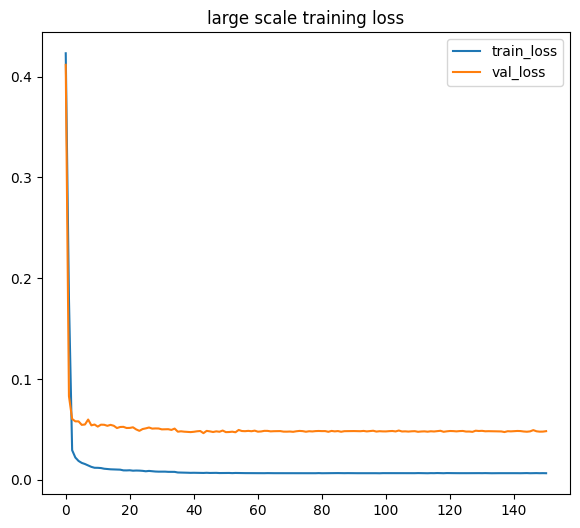

In [39]:
data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley', 'large scale']
data_path_list = ['large scale']
i = 1
fig = plt.figure(figsize=(15, 6))
fig.tight_layout()
args.epochs = 150
for data in data_path_list:
    
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    args.train_list = osp.join(args.root_dir, 'Train.txt')
    args.val_list = osp.join(args.root_dir, 'Validation.txt')
    args.out_dir = osp.join(args.root_dir, args.type + '_outputs')
    args.model_path = osp.join(args.out_dir, 'checkpoints/checkpoint_latest.pt')
    #args.continue_from = args.model_path
    args.continue_from = None
    train_losses, val_losses = train(args)
    plt.subplot(math.ceil(len(data_path_list) / 2), 2 , i)
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title(data+' training loss')
    plt.legend(['train_loss', 'val_loss'])
    i += 1


=============================================================================outputs for large scale ==============================================================
step_size: 10, window_size: 200
Model /home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/large scale/resnet_outputs/checkpoints/checkpoint_latest.pt loaded to device cuda:0.
step_size: 10, window_size: 200
target shape:  (1530, 2)
length of pos_pred in func (bfore inter:  (1532, 2)
pos shape final: (15499, 2)
length of pos_pred:  (15499, 2)
length of pos_gt:  (15499, 2)
Sequence floor1/combined8.csv, loss [0.067879 0.046589] / 0.0572342723608017, ate 4.084601, rte 2.954062
length of predictions:  1530
length of predictions:  1530


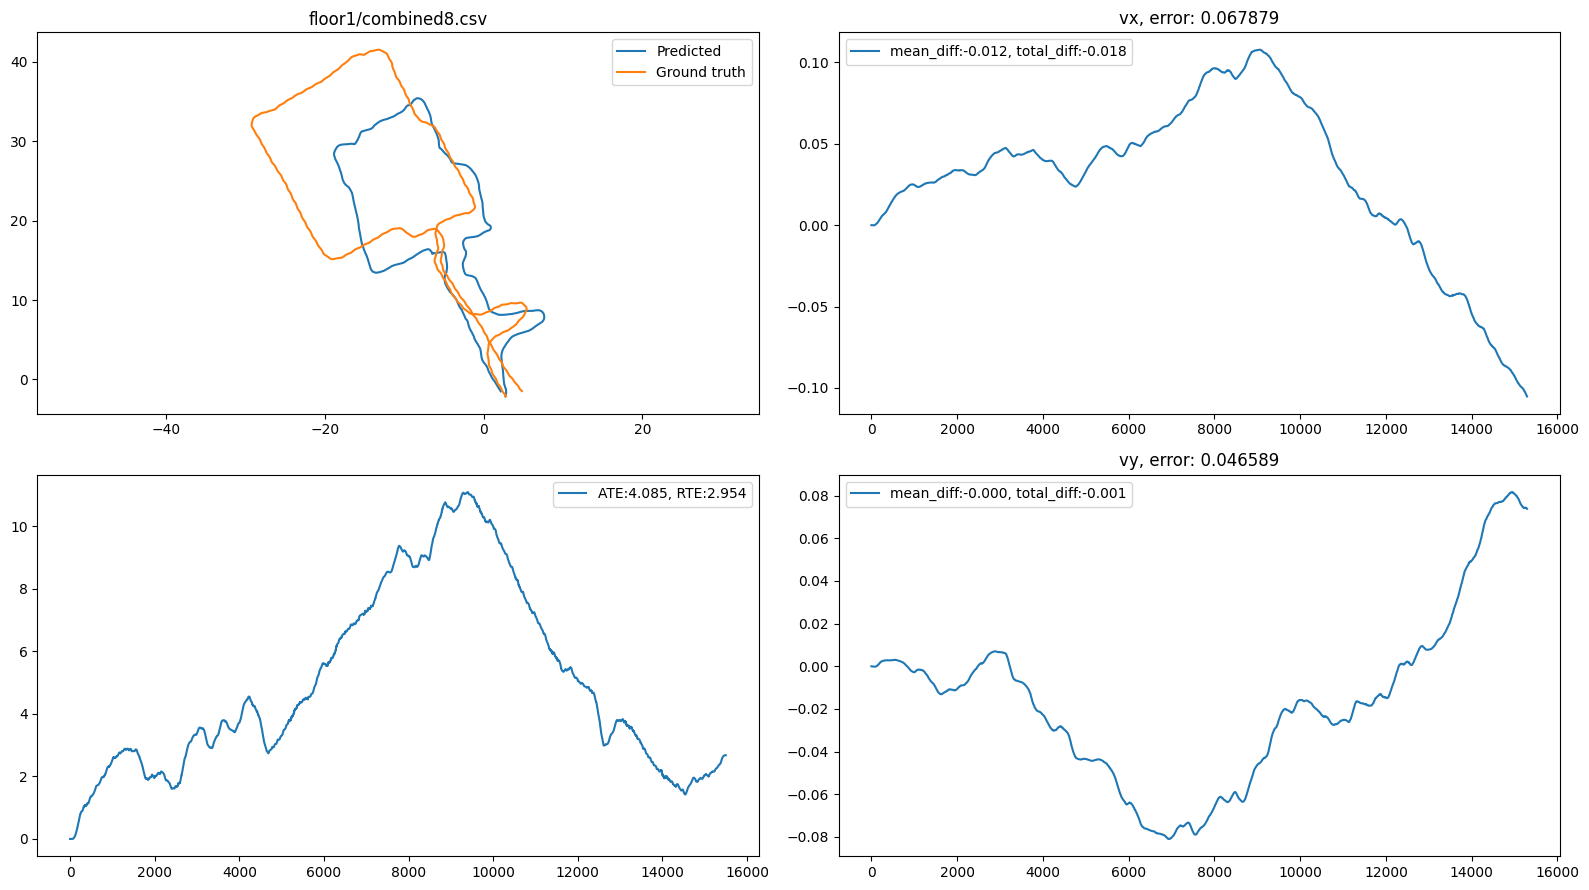

step_size: 10, window_size: 200
target shape:  (1580, 2)
length of pos_pred in func (bfore inter:  (1582, 2)
pos shape final: (15999, 2)
length of pos_pred:  (15999, 2)
length of pos_gt:  (15999, 2)
Sequence floor1/combined9.csv, loss [0.062421 0.083129] / 0.07277536392211914, ate 8.878111, rte 6.065221
length of predictions:  1580
length of predictions:  1580


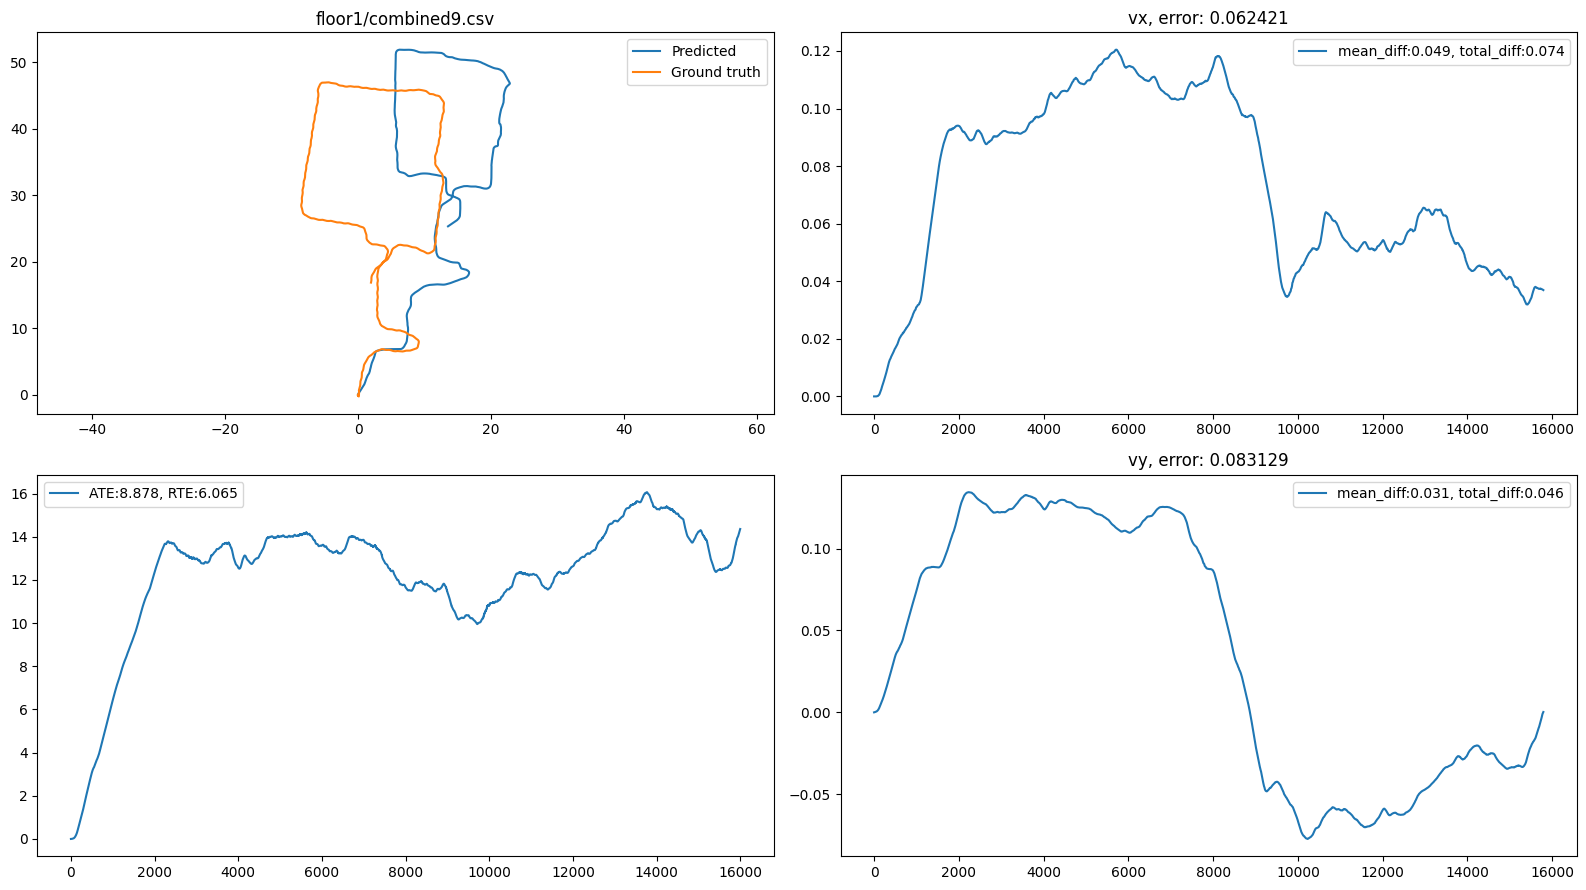

step_size: 10, window_size: 200
target shape:  (1570, 2)
length of pos_pred in func (bfore inter:  (1572, 2)
pos shape final: (15899, 2)
length of pos_pred:  (15899, 2)
length of pos_gt:  (15899, 2)
Sequence floor4/combined16.csv, loss [0.080949 0.123330] / 0.1021394431591034, ate 6.093739, rte 5.539791
length of predictions:  1570
length of predictions:  1570


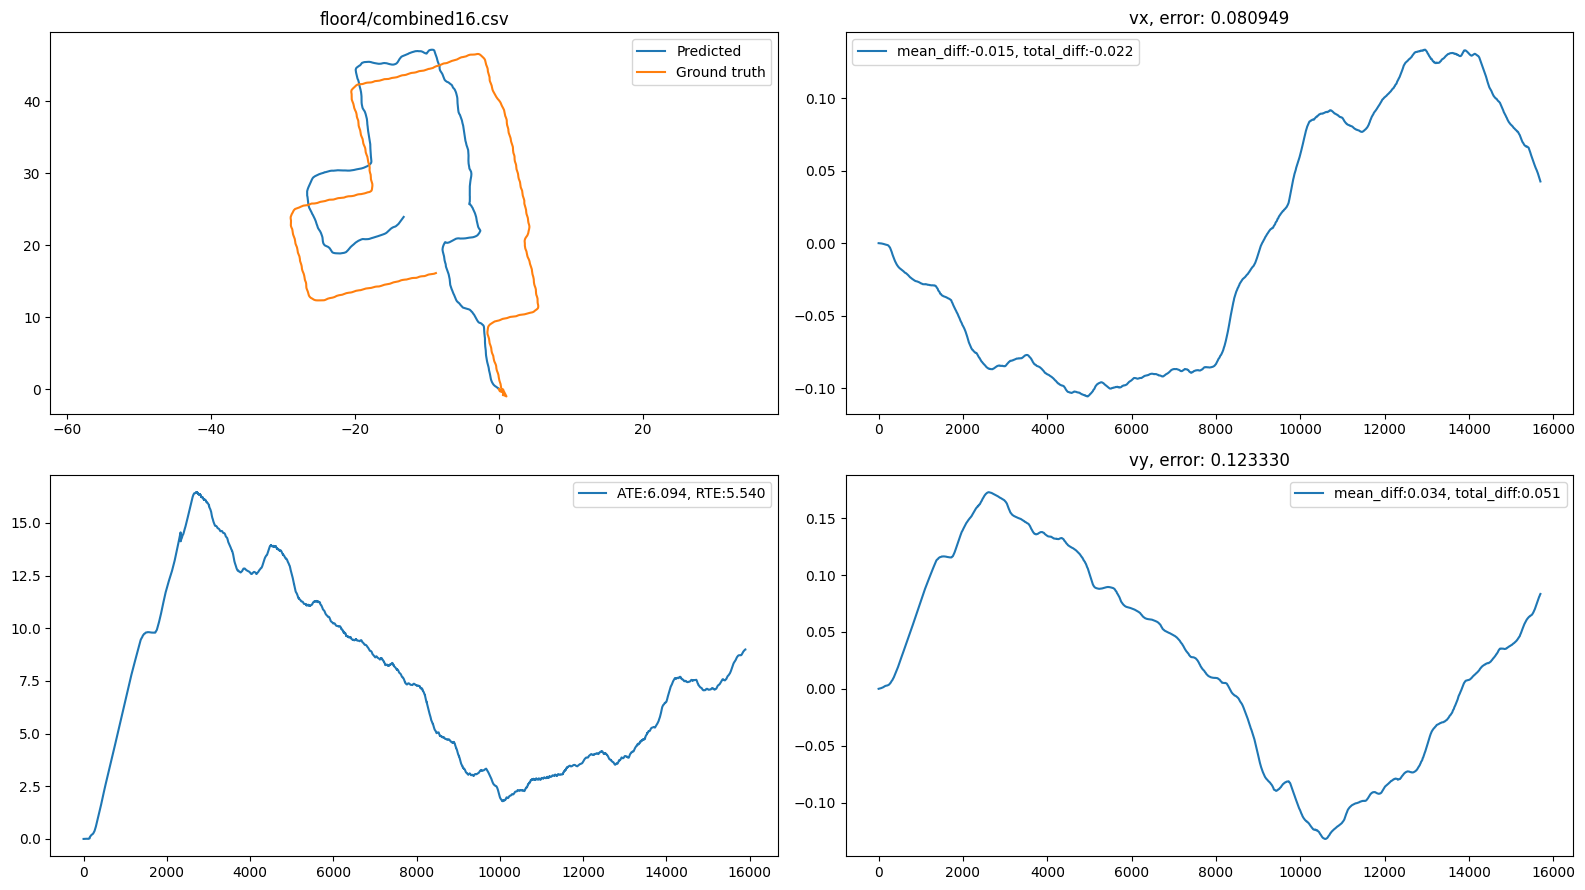

step_size: 10, window_size: 200
target shape:  (1580, 2)
length of pos_pred in func (bfore inter:  (1582, 2)
pos shape final: (15999, 2)
length of pos_pred:  (15999, 2)
length of pos_gt:  (15999, 2)
Sequence floor4/combined17.csv, loss [0.053303 0.067201] / 0.06025204807519913, ate 8.831827, rte 5.732055
length of predictions:  1580
length of predictions:  1580


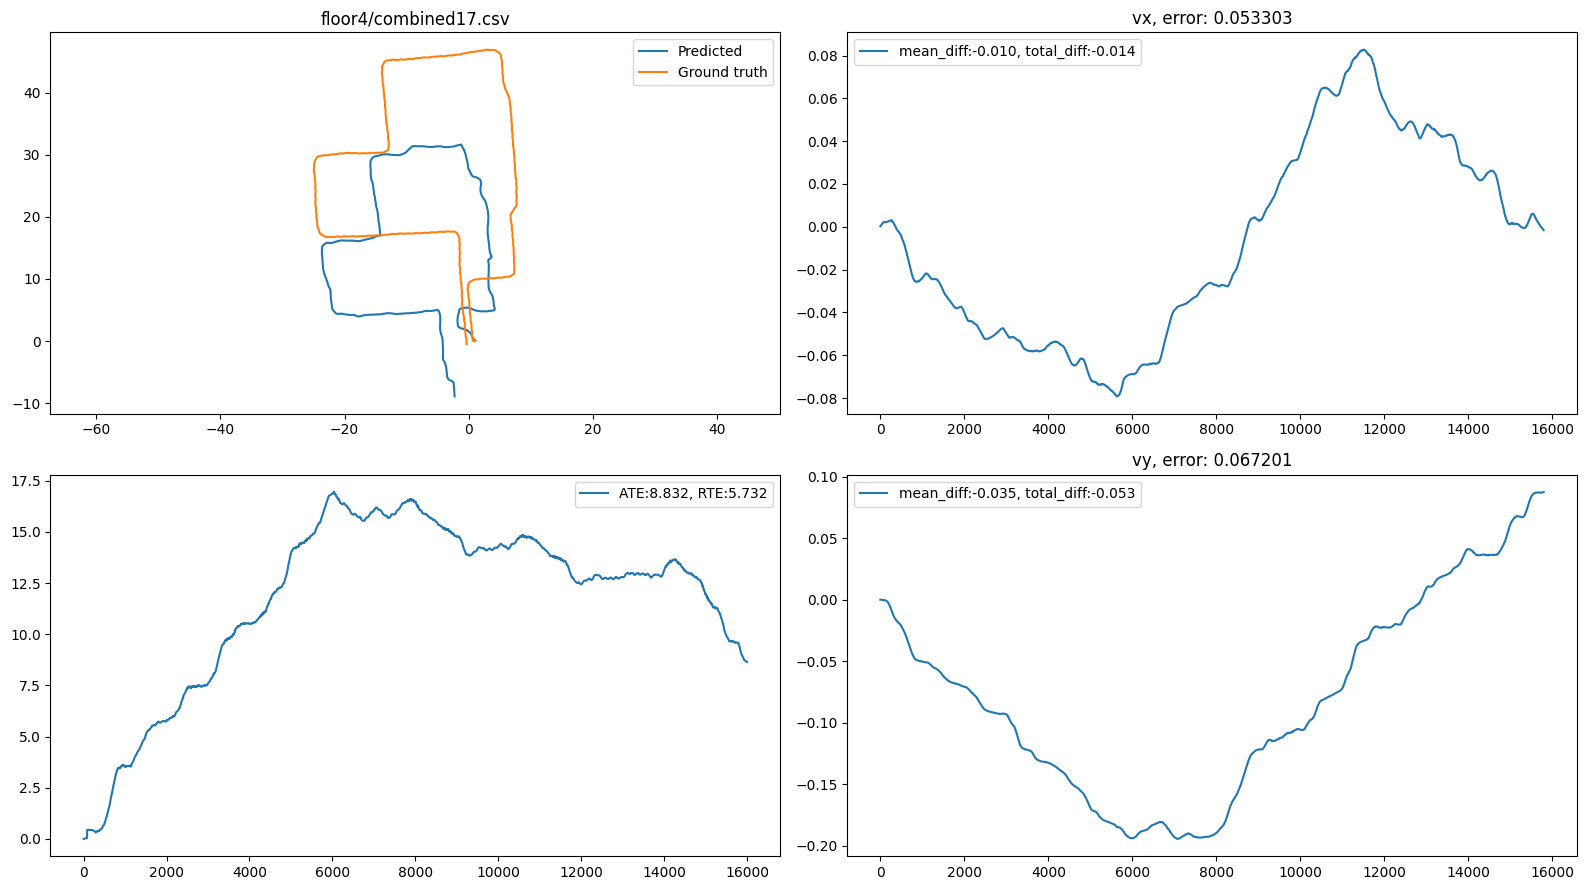

step_size: 10, window_size: 200
target shape:  (1540, 2)
length of pos_pred in func (bfore inter:  (1542, 2)
pos shape final: (15599, 2)
length of pos_pred:  (15599, 2)
length of pos_gt:  (15599, 2)
Sequence floor4/combined18.csv, loss [0.082239 0.114250] / 0.09824450314044952, ate 13.233360, rte 11.597486
length of predictions:  1540
length of predictions:  1540


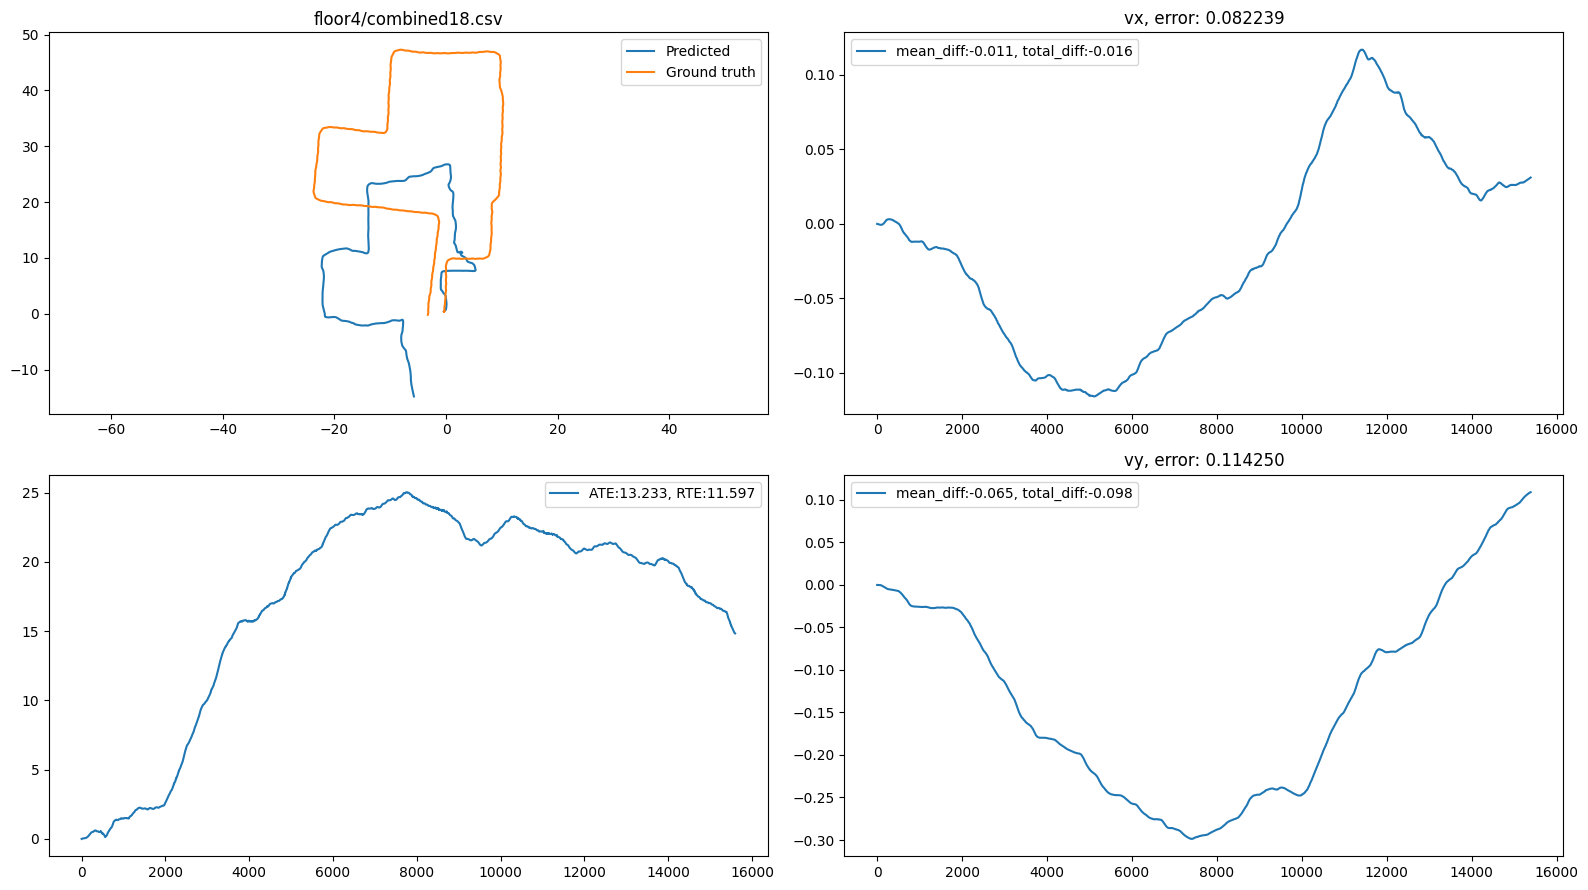

----------
Overall loss: [0.069358 0.086900]/0.0781291276216507, avg ATE:8.224327779207092, avg RTE:6.3777230350974445


In [44]:
args.feature_sigma = 2
args.target_sigma = -1
args.saveAnim = False
args.step_size = 10
data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley', 'large scale']
data_path_list = ['large scale']
for data in data_path_list:
    print(f'=============================================================================outputs for {data} ==============================================================')
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    args.test_list = osp.join(args.root_dir, 'Test.txt')
    args.out_dir = osp.join(args.root_dir, args.type + '_outputs')
    args.model_path = osp.join(args.out_dir, 'checkpoints/checkpoint_latest.pt')
    test_sequence(args)

## Combine all outputs to view results clearly

<Axes: title={'center': 'ResNet prediction Error in domain'}, xlabel='seq', ylabel='Error(m)'>

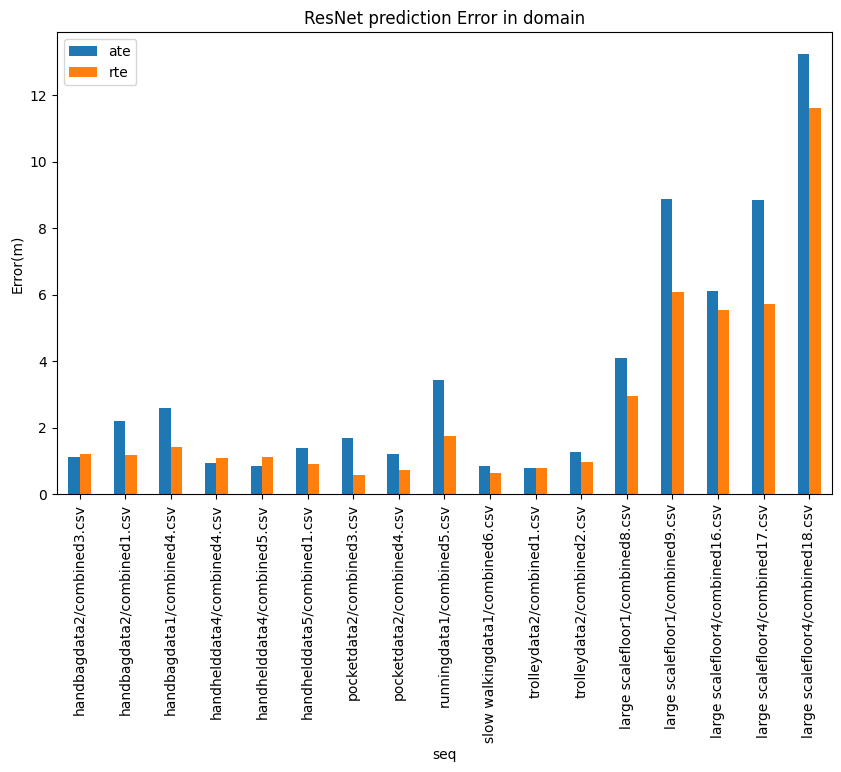

In [41]:
data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley', 'large scale']
#results_df = pd.DataFrame(columns = ['seq', 'ate', 'rte', 'TX_ate', 'TX_rte'])
results_df = pd.DataFrame(columns = ['seq', 'ate', 'rte'])
for data in data_path_list:
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    #txData = pd.read_csv(osp.join(args.root_dir, 'txLearning_outputs/losses.csv'))[['TX_ate', 'TX_rte']]
    Data = pd.read_csv(osp.join(args.root_dir, args.type+'_outputs/losses.csv'))[['seq', 'ate', 'rte']]
    #combined = pd.concat([Data, txData], axis = 1)
    combined = pd.concat([Data], axis = 1)
    results_df = pd.concat([results_df, combined], axis = 0)
    #results_df = pd.concat([results_df, Data], axis = 0)

fig, ax = plt.subplots(figsize=(10, 6))
#results_df.plot(x='seq', y=['ate', 'rte', 'TX_ate', 'TX_rte'], kind='bar', ax = ax, title = 'ResNet prediction Error in domain', ylabel = 'Error(m)')
results_df.plot(x='seq', y=['ate', 'rte'], kind='bar', ax = ax, title = 'ResNet prediction Error in domain', ylabel = 'Error(m)')

<Axes: title={'center': 'ResNet prediction Error in domain'}, xlabel='seq', ylabel='Error(m)'>

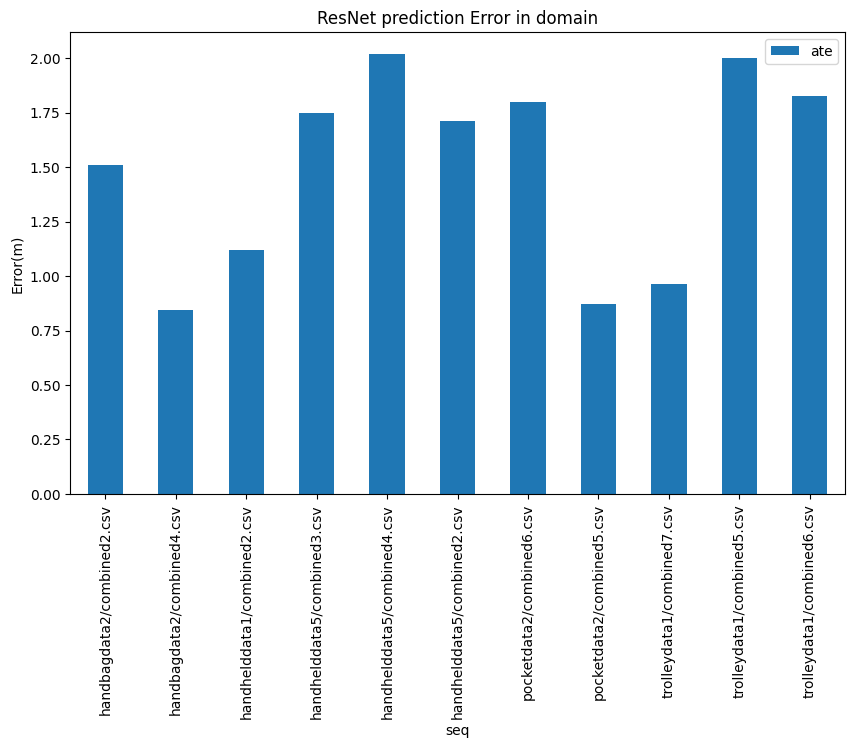

In [18]:
#data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley', 'large scale']
data_path_list = ['slow walking', 'handheld', 'running']
data_path_list = ['handbag', 'handheld', 'pocket', 'trolley']
#results_df = pd.DataFrame(columns = ['seq', 'ate', 'rte', 'TX_ate', 'TX_rte'])
results_df = pd.DataFrame(columns = ['seq', 'ate'])
for data in data_path_list:
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    #txData = pd.read_csv(osp.join(args.root_dir, 'txLearning_outputs/losses.csv'))[['TX_ate', 'TX_rte']]
    Data = pd.read_csv(osp.join(args.root_dir, args.type+'_outputs/losses.csv'))[['seq', 'ate']]
    #combined = pd.concat([Data, txData], axis = 1)
    combined = pd.concat([Data], axis = 1)
    results_df = pd.concat([results_df, combined], axis = 0)
    #results_df = pd.concat([results_df, Data], axis = 0)

fig, ax = plt.subplots(figsize=(10, 6))
#results_df.plot(x='seq', y=['ate', 'rte', 'TX_ate', 'TX_rte'], kind='bar', ax = ax, title = 'ResNet prediction Error in domain', ylabel = 'Error(m)')
results_df.plot(x='seq', y=['ate'], kind='bar', ax = ax, title = 'ResNet prediction Error in domain', ylabel = 'Error(m)')

<Axes: title={'center': 'ResNet prediction Error in domain'}, xlabel='seq', ylabel='Error(m)'>

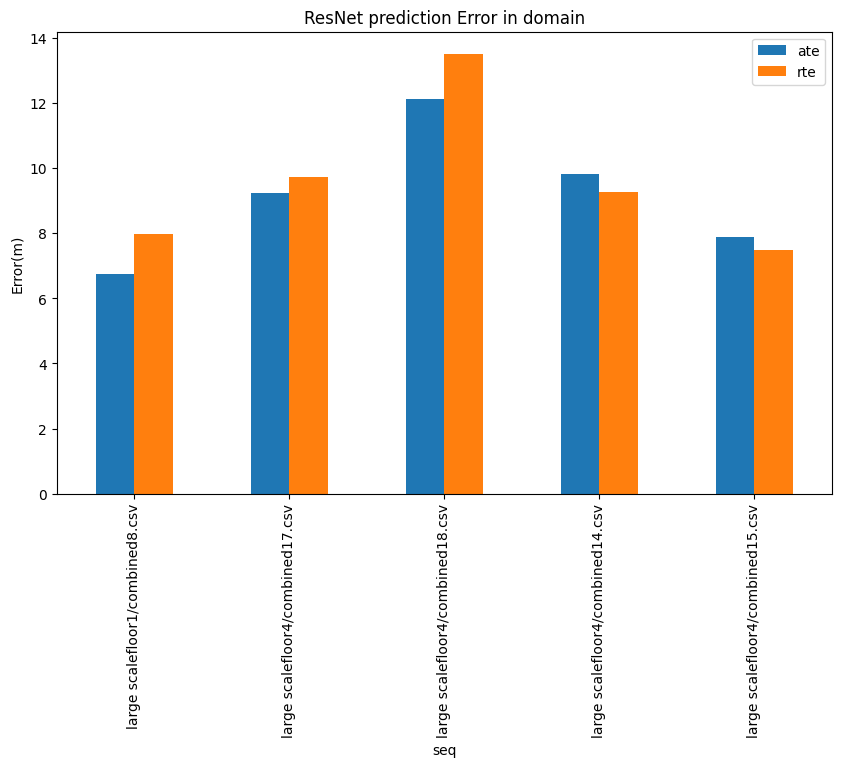

In [20]:
#data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley', 'large scale']
data_path_list = ['large scale']
#results_df = pd.DataFrame(columns = ['seq', 'ate', 'rte', 'TX_ate', 'TX_rte'])
results_df = pd.DataFrame(columns = ['seq', 'ate', 'rte'])
for data in data_path_list:
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    #txData = pd.read_csv(osp.join(args.root_dir, 'txLearning_outputs/losses.csv'))[['TX_ate', 'TX_rte']]
    Data = pd.read_csv(osp.join(args.root_dir, args.type+'_outputs/losses.csv'))[['seq', 'ate', 'rte']]
    #combined = pd.concat([Data, txData], axis = 1)
    combined = pd.concat([Data], axis = 1)
    results_df = pd.concat([results_df, combined], axis = 0)
    #results_df = pd.concat([results_df, Data], axis = 0)

fig, ax = plt.subplots(figsize=(10, 6))
#results_df.plot(x='seq', y=['ate', 'rte', 'TX_ate', 'TX_rte'], kind='bar', ax = ax, title = 'ResNet prediction Error in domain', ylabel = 'Error(m)')
results_df.plot(x='seq', y=['ate', 'rte'], kind='bar', ax = ax, title = 'ResNet prediction Error in domain', ylabel = 'Error(m)')

In [ ]:
data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley', 'large scale']
for data in data_path_list:
    print(data)
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    args.train_list = osp.join(args.root_dir, 'Train.txt')
    train_dataset = get_dataset_from_list(args.root_dir, args.train_list, args,  mode='train')
    print('Number of train samples: {}'.format(len(train_dataset)))

## Training model on its own domain

In [ ]:
data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley', 'large scale']
i = 1
fig = plt.figure(figsize=(15, 6))
fig.tight_layout()
for data in data_path_list:
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    args.train_list = osp.join(args.root_dir, 'Train-small.txt')
    args.val_list = osp.join(args.root_dir, 'Validation.txt')
    args.out_dir = osp.join(args.root_dir, 'small_outputs')
    args.model_path = osp.join(args.out_dir, 'checkpoints/checkpoint_latest.pt') 
    train_losses, val_losses = train(args)
    plt.subplot(math.ceil(len(data_path_list) / 2), 2 , i)
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title(data+' training loss')
    plt.legend(['train_loss', 'val_loss'])
    i += 1


In [ ]:
args.feature_sigma = 2
args.target_sigma = -1
args.saveAnim = False
data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley', 'large scale']
for data in data_path_list:
    print(f'=============================================================================outputs for {data} ==============================================================')
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    args.test_list = osp.join(args.root_dir, 'Test.txt')
    args.out_dir = osp.join(args.root_dir, 'small_outputs')
    args.model_path = osp.join(args.out_dir, 'checkpoints/checkpoint_latest.pt')
    test_sequence(args)

## Transfer learning by pretrained ronin model

In [ ]:
data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley', 'large scale']
i = 1
fig = plt.figure(figsize=(15, 6))
fig.tight_layout()
for data in data_path_list:
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    args.train_list = osp.join(args.root_dir, 'Train-small.txt')
    args.val_list = osp.join(args.root_dir, 'Validation.txt')
    args.model_path = osp.join(args.out_dir, 'checkpoints/checkpoint_latest.pt')
    args.out_dir = osp.join(args.root_dir, 'small_txLearning_outputs')
    args.transfer_from = '/home/jovyan/ronin/PreTrained_Models/ronin_resnet/ronin_resnet/checkpoint_gsn_latest.pt'
    train_losses, val_losses = train(args)
    plt.subplot(math.ceil(len(data_path_list) / 2), 2 , i)
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title(data+' training loss')
    plt.legend(['train_loss', 'val_loss'])
    i += 1


In [ ]:
args.saveAnim = False
data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley', 'large scale']
for data in data_path_list:
    print(f'=============================================================================outputs for {data} ==============================================================')
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    args.test_list = osp.join(args.root_dir, 'Test.txt')
    args.out_dir = osp.join(args.root_dir, 'small_txLearning_outputs')
    args.model_path = osp.join(args.out_dir, 'checkpoints/checkpoint_latest.pt')
    test_sequence(args)
   

## Combine all outputs to see data

In [ ]:
data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley', 'large scale']
results_df = pd.DataFrame(columns = ['seq', 'ate', 'rte', 'TX_ate', 'TX_rte'])
for data in data_path_list:
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    txData = pd.read_csv(osp.join(args.root_dir, 'small_txLearning_outputs/losses.csv'))[['TX_ate', 'TX_rte']]
    Data = pd.read_csv(osp.join(args.root_dir, 'small_outputs/losses.csv'))[['seq', 'ate', 'rte']]
    combined = pd.concat([Data, txData], axis = 1)
    results_df = pd.concat([results_df, combined], axis = 0)
fig, ax = plt.subplots(figsize=(10, 6))
results_df.plot(x='seq', y=['ate', 'rte', 'TX_ate', 'TX_rte'], kind='bar', ax = ax, title = 'ResNet prediction Error in domain (small dataset)', ylabel = 'Error(m)')

# Tuning Hyper Parameters

#### Parameters to tune:

### Current
- batch_size
- learning rate
- fc_dim
- dropout
- trans_planes
- window_size
- step_size

In [ ]:
! pip install ray
from functools import partial
from ray import tune
from ray.air import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler

In [ ]:
_fc_config = {'fc_dim': 512, 'in_dim': 4, 'dropout': 0.5, 'trans_planes': 128}

In [ ]:
def train_tune(config, data_dir):
    args.batch_size = config['batch_size']
    args.lr = config['lr']
    args.window_size = config['window_size']
    args.step_size = config['step_size']
    
    global _fc_config
    _fc_config['fc_dim'] = config['fc_dim']
    _fc_config['dropout'] = config['dropout']
    _fc_config['trans_planes'] = config['trans_planes']
    
    # Loading data
    start_t = time.time()
    train_dataset = get_dataset_from_list(args.root_dir, args.train_list, args,  mode='train')
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

    end_t = time.time()
    print('Training set loaded. Feature size: {}, target size: {}. Time usage: {:.3f}s'.format(
        train_dataset.feature_dim, train_dataset.target_dim, end_t - start_t))
    
    val_dataset, val_loader = None, None
    if args.val_list is not None:
        val_dataset = get_dataset_from_list(args.root_dir, args.val_list, args, mode='val')
        val_loader = DataLoader(val_dataset, batch_size=512, shuffle=True)
    device = torch.device('cuda:0' if torch.cuda.is_available() and not args.cpu else 'cpu')

    summary_writer = None
    
    if args.out_dir is not None:
        if not osp.isdir(args.out_dir):
            os.makedirs(args.out_dir)
        write_config(args)
            
        if not osp.isdir(osp.join(args.out_dir, 'checkpoints')):
            os.makedirs(osp.join(args.out_dir, 'checkpoints'))
        if not osp.isdir(osp.join(args.out_dir, 'logs')):
            os.makedirs(osp.join(args.out_dir, 'logs'))

    
    _fc_config['in_dim'] = args.window_size // 32 + 1
    network = ResNet1D(_input_channel, _output_channel, BasicBlock1D, [2, 2, 2, 2],
                           base_plane=64, output_block=FCOutputModule, kernel_size=3, **_fc_config)
    network.to(device)

    
    
    print('Number of train samples: {}'.format(len(train_dataset)))
    if val_dataset:
        print('Number of val samples: {}'.format(len(val_dataset)))
    total_params = network.get_num_params()
    print('Total number of parameters: ', total_params)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), args.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True, eps=1e-12)

    checkpoint = session.get_checkpoint()
    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        network.load_state_dict(checkpoint_state["model_state_dict"])
        optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0      
    step = 0
    best_val_loss = np.inf

    print('Start from epoch {}'.format(start_epoch))
    total_epoch = start_epoch
    train_losses_all, val_losses_all = [], []

    # Get the initial loss, this should be with the randomised weights
    init_train_targ, init_train_pred = run_test(network, train_loader, device, eval_mode=False)

    init_train_loss = np.mean((init_train_targ - init_train_pred) ** 2, axis=0)
    train_losses_all.append(np.mean(init_train_loss))
    print('-------------------------')
    print('Init: average loss: {}/{:.6f}'.format(init_train_loss, train_losses_all[-1]))
    if summary_writer is not None:
        add_summary(summary_writer, init_train_loss, 0, 'train')

    if val_loader is not None:
        init_val_targ, init_val_pred = run_test(network, val_loader, device)
        init_val_loss = np.mean((init_val_targ - init_val_pred) ** 2, axis=0)
        val_losses_all.append(np.mean(init_val_loss))
        print('Validation loss: {}/{:.6f}'.format(init_val_loss, val_losses_all[-1]))
        if summary_writer is not None:
            add_summary(summary_writer, init_val_loss, 0, 'val')

    try:
        for epoch in range(start_epoch, args.epochs):
            start_t = time.time()
            network.train()
            train_outs, train_targets = [], []
            for batch_id, (feat, targ, _, _) in enumerate(train_loader):
                feat, targ = feat.to(device), targ.to(device)
                optimizer.zero_grad()
                pred = network(feat)
                train_outs.append(pred.cpu().detach().numpy())
                train_targets.append(targ.cpu().detach().numpy())
                loss = criterion(pred, targ)
                loss = torch.mean(loss)
                loss.backward()
                optimizer.step()
                step += 1
            train_outs = np.concatenate(train_outs, axis=0)
            train_targets = np.concatenate(train_targets, axis=0)
            train_losses = np.average((train_outs - train_targets) ** 2, axis=0)

            end_t = time.time()
            if epoch%20 == 0:    
                print('-------------------------')
                print('Epoch {}, time usage: {:.3f}s, average loss: {}/{:.6f}'.format(
                    epoch, end_t - start_t, train_losses, np.average(train_losses)))
                train_losses_all.append(np.average(train_losses))

            if summary_writer is not None:
                add_summary(summary_writer, train_losses, epoch + 1, 'train')
                summary_writer.add_scalar('optimizer/lr', optimizer.param_groups[0]['lr'], epoch)

            #if we have a validation dataset, checkpoint is saved based on the best validation loss
            if val_loader is not None:
                network.eval()
                val_outs, val_targets = run_test(network, val_loader, device)
                val_losses = np.average((val_outs - val_targets) ** 2, axis=0)
                avg_loss = np.average(val_losses)
                if epoch%20 == 0:
                    print('Validation loss: {}/{:.6f}'.format(val_losses, avg_loss))
                scheduler.step(avg_loss)
                if summary_writer is not None:
                    add_summary(summary_writer, val_losses, epoch + 1, 'val')
                val_losses_all.append(avg_loss)
                if avg_loss < best_val_loss:
                    best_val_loss = avg_loss
                    if args.out_dir and osp.isdir(args.out_dir):
                        model_path = osp.join(args.out_dir, 'checkpoints', 'checkpoint_%d.pt' % epoch)
                        torch.save({'model_state_dict': network.state_dict(),
                                    'epoch': epoch,
                                    'optimizer_state_dict': optimizer.state_dict()}, model_path)
                        print('Model saved to ', model_path)
            else:
                if args.out_dir is not None and osp.isdir(args.out_dir):
                    model_path = osp.join(args.out_dir, 'checkpoints', 'checkpoint_%d.pt' % epoch)
                    torch.save({'model_state_dict': network.state_dict(),
                                'epoch': epoch,
                                'optimizer_state_dict': optimizer.state_dict()}, model_path)
                    print('Model saved to ', model_path)

            total_epoch = epoch
            checkpoint_data = {
            "epoch": epoch,
            "model_state_dict": network.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()
            }
            checkpoint = Checkpoint.from_dict(checkpoint_data)
            
            session.report({"loss": avg_loss},checkpoint=checkpoint)

    except KeyboardInterrupt:
        print('-' * 60)
        print('Early terminate')

    print('Training complete')
    if args.out_dir:
        model_path = osp.join(args.out_dir, 'checkpoints', 'checkpoint_latest.pt')
        torch.save({'model_state_dict': network.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': total_epoch}, model_path)
        print('Checkpoint saved to ', model_path)

    return train_losses_all, val_losses_all

In [ ]:
def test_tune(best_trial, args):
    args.mode = 'test'
    if args.test_path is not None:
        if args.test_path[-1] == '/':
            args.test_path = args.test_path[:-1]
        root_dir = osp.split(args.test_path)[0]
        test_data_list = [osp.split(args.test_path)[1]]
    elif args.test_list is not None:
        root_dir = args.root_dir
        with open(args.test_list) as f:
            test_data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    else:
        raise ValueError('Either test_path or test_list must be specified.')

    if args.out_dir is not None and not osp.isdir(args.out_dir):
        os.makedirs(args.out_dir)

    if not osp.isdir(osp.join(args.out_dir, 'Videos')) or not osp.isdir(osp.join(args.out_dir, 'Graphs')):
        os.makedirs(osp.join(args.out_dir, 'Videos'))
        os.makedirs(osp.join(args.out_dir, 'Graphs'))
        


    if not torch.cuda.is_available() or args.cpu:
        device = torch.device('cpu')
        checkpoint = torch.load(args.model_path, map_location=lambda storage, location: storage)
    else:
        device = torch.device('cuda:0')
        checkpoint = torch.load(args.model_path)

    # Load the first sequence to update the input and output size
    _ = get_dataset(root_dir, [test_data_list[0]], args)
    
    
    best_checkpoint = best_trial.checkpoint.to_air_checkpoint()
    best_checkpoint_data = best_checkpoint.to_dict()
    
    global _fc_config
    _fc_config['fc_dim'] = best_trial.config['fc_dim']
    _fc_config['dropout'] = best_trial.config['dropout']
    _fc_config['trans_planes'] = best_trial.config['trans_planes']
    args.window_size = best_trial.config['window_size']
    _fc_config['in_dim'] = args.window_size // 32 + 1
    network = ResNet1D(_input_channel, _output_channel, BasicBlock1D, [2, 2, 2, 2],
                           base_plane=64, output_block=FCOutputModule, kernel_size=3, **_fc_config)

    network.load_state_dict(best_checkpoint_data["model_state_dict"])
    network.eval().to(device)
    print('Model {} loaded to device {}.'.format(args.model_path, device))

    preds_seq, targets_seq, losses_seq, ate_all, rte_all = [], [], [], [], []
    traj_lens = []

    pred_per_min = 200 * 60

    for data in test_data_list:
        seq_dataset = get_dataset(root_dir, [data], args, mode='test')
        seq_loader = DataLoader(seq_dataset, batch_size=1024, shuffle=False)
        ind = np.array([i[1] for i in seq_dataset.index_map if i[0] == 0], dtype=np.int32)

        targets, preds = run_test(network, seq_loader, device, True)
        losses = np.mean((targets - preds) ** 2, axis=0)
        preds_seq.append(preds)
        targets_seq.append(targets)
        losses_seq.append(losses)
        
        pos_pred = recon_traj_with_preds(seq_dataset, preds)[:, :2]
        pos_gt = seq_dataset.gt_pos[0][:, :2]

        # Calculates length of a trajectory and appends into list
        traj_lens.append(np.sum(np.linalg.norm(pos_gt[1:] - pos_gt[:-1], axis=1)))
        ate, rte = compute_ate_rte(pos_pred, pos_gt, pred_per_min)
        ate_all.append(ate)
        rte_all.append(rte)
        pos_cum_error = np.linalg.norm(pos_pred - pos_gt, axis=1)

        print('Sequence {}, loss {} / {}, ate {:.6f}, rte {:.6f}'.format(data, losses, np.mean(losses), ate, rte))

        targ_names = ['vx', 'vy']
        kp = 2
        
        
        if args.out_dir is not None and osp.isdir(args.out_dir) and args.saveAnim:
            video_path = osp.join(args.out_dir, 'Videos/' + ''.join(data.split('/')) +'_Trajectory.mp4')
            animation = plotTrajectory(pos_gt[:, 0], pos_gt[:, 1], pos_pred[:, 0], pos_pred[:, 1])
            animation.save(video_path, writer = 'ffmpeg', fps = 50, bitrate = 700)
            showAnimation(video_path)

        plt.figure('{}'.format(data), figsize=(16, 9))
        plt.subplot2grid((kp, 2), (0, 0), rowspan=kp - 1)
        plt.plot(pos_pred[:, 0], pos_pred[:, 1])
        plt.plot(pos_gt[:, 0], pos_gt[:, 1])
        plt.title(data)
        plt.axis('equal')
        plt.legend(['Predicted', 'Ground truth'])
        plt.subplot2grid((kp, 2), (kp - 1, 0))
        plt.plot(pos_cum_error)
        plt.legend(['ATE:{:.3f}, RTE:{:.3f}'.format(ate_all[-1], rte_all[-1])])
        for i in range(kp):
            plt.subplot2grid((kp, 2), (i, 1))
            plt.plot(ind, preds[:, i])
            plt.plot(ind, targets[:, i])
            plt.legend(['Predicted', 'Ground truth'])
            plt.title('{}, error: {:.6f}'.format(targ_names[i], losses[i]))
        plt.tight_layout()
        
        if args.out_dir is not None and osp.isdir(args.out_dir):
            np.save(osp.join(args.out_dir, 'Graphs/'+''.join(data.split('/')) + '_gsn.npy'),
                    np.concatenate([pos_pred[:, :2], pos_gt[:, :2]], axis=1))
            plt.savefig(osp.join(args.out_dir, 'Graphs/'+''.join(data.split('/')) + '_gsn.png'))
        
        if args.show_plot:
            plt.show()
        plt.close('all')   

    losses_seq = np.stack(losses_seq, axis=0)
    losses_avg = np.mean(losses_seq, axis=1)
    # Export a csv file
    seq_name = root_dir.split('/')[-1]
    model_type = ''
    if 'txLearning_outputs' in args.model_path:
        model_type = 'TX_'
    if args.out_dir is not None and osp.isdir(args.out_dir):
        with open(osp.join(args.out_dir, 'losses.csv'), 'w') as f:
            if losses_seq.shape[1] == 2:
                f.write(f'seq,vx,vy,avg,{model_type}ate,{model_type}rte\n')
            else:
                f.write(f'seq,vx,vy,vz,avg,{model_type}ate,{model_type}rte\n')
            for i in range(losses_seq.shape[0]):
                f.write(seq_name+'{},'.format(test_data_list[i]))
                for j in range(losses_seq.shape[1]):
                    f.write('{:.6f},'.format(losses_seq[i][j]))
                f.write('{:.6f},{:6f},{:.6f}\n'.format(losses_avg[i], ate_all[i], rte_all[i]))

    print('----------\nOverall loss: {}/{}, avg ATE:{}, avg RTE:{}'.format(
        np.average(losses_seq, axis=0), np.average(losses_avg), np.mean(ate_all), np.mean(rte_all)))
    return losses_avg

In [ ]:
config = {
    "batch_size": tune.choice([256,512]),
    "fc_dim": tune.choice([256, 512, 1024]),
    "dropout": tune.choice([0.3, 0.4, 0.5]),
    "trans_planes": tune.choice([64, 128, 256]),
    "lr": tune.loguniform(1e-04, 1e-1),
    "window_size": tune.choice([50, 100, 200, 300]),
    "step_size": tune.choice([10, 15, 20, 5])
}

# config = {
#     "batch_size": tune.choice([32]),
#     "fc_dim": tune.choice([512]),
#     "dropout": tune.choice([0.5]),
#     "trans_planes": tune.choice([128]),
#     "lr": tune.loguniform(1e-04, 1e-04),
#     "window_size": tune.choice([200]),
#     "step_size": tune.choice([10])
# }

args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', 'handbag')
args.train_list = osp.join(args.root_dir, 'Train.txt')
args.val_list = osp.join(args.root_dir, 'Validation.txt')
args.out_dir = 'home/jovyan/dummyoutput'
args.epochs = 100

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=args.epochs,
        grace_period=20,
        reduction_factor=2,
    )
result = tune.run(
    partial(train_tune, data_dir=args.root_dir),
    resources_per_trial={"cpu": 2, "gpu": 1},
    config=config,
    num_samples=15,
    scheduler= scheduler,
    checkpoint_at_end=False)

In [ ]:
args.saveAnim = False
best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
args.out_dir = 'home/jovyan/dummyoutput'
args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', 'handbag')
args.test_list = osp.join(args.root_dir, 'Validation.txt')

test_tune(best_trial, args)

In [ ]:
from torch.utils.data import DataLoader
seq_dataset = get_dataset('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/handbag', ['data1/combined1.csv'], args, mode='train')
seq_loader = DataLoader(seq_dataset, batch_size=16, shuffle=False)

In [ ]:
network = ResNet1D(_input_channel, _output_channel, BasicBlock1D, [2, 2, 2, 2],
                           base_plane=64, output_block=FCOutputModule, kernel_size=3, **_fc_config)
input_names = ["input"]
output_names = ["output"]

for bid, (feat, targ, _, _) in enumerate(seq_loader):
    print(feat.shape)
    torch.onnx.export(network, feat, "model.onnx", input_names=input_names, output_names=output_names)
    break
